# Logistic Regression with and without scikit

# Lista 1 - Redes Neurais
## Daniel de Amaral da Silva
## Estatística - 385802

## Load Data | EDA

### Import libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load Dataset

In [0]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data', header = None)
df.columns = ['class','age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat']

In [71]:
df.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


Cells wrong in breast and breast-quad

In [72]:
count = 0
for i in range(df.shape[0]):
  if ((df.iloc[i, 7] == 'left') and (df.iloc[i, 8] == 'left_up')) or ((df.iloc[i, 7] == 'left') and (df.iloc[i, 8] == 'left_low')):
    pass
  elif ((df.iloc[i, 7] == 'right') and (df.iloc[i, 8] == 'right_up')) or ((df.iloc[i, 7] == 'right') and (df.iloc[i, 8] == 'right_low')):
    pass
  else:
    count += 1
print(f'Há {count} observações em que o lado afetado não corresponde ao quadrante')
print(f'Exemplo: \n{df.iloc[9, [7, 8]]}')

Há 141 observações em que o lado afetado não corresponde ao quadrante
Exemplo: 
breast           right
breast-quad    left_up
Name: 9, dtype: object


Drop the 'breast-quad' collumn

In [0]:
df.drop(['breast-quad'], axis= 1 ,inplace=True)

### Heatmap

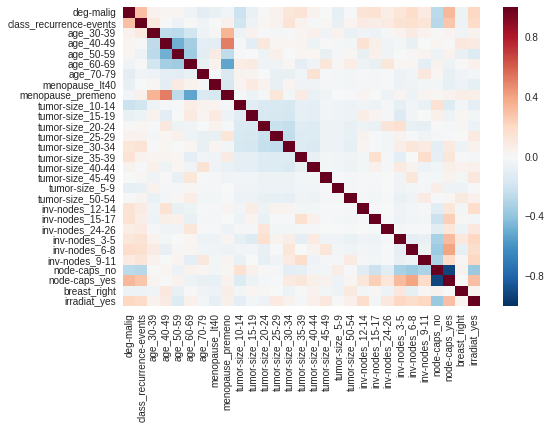

In [74]:
import seaborn as sns
corr = pd.get_dummies(df, drop_first = True).corr()
sns.heatmap(corr)
sns.plt.show()

### Describe

In [75]:
df.describe()

,deg-malig
count,286.000000
mean,2.048951
std,0.738217
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,3.000000


### info

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 9 columns):
class         286 non-null object
age           286 non-null object
menopause     286 non-null object
tumor-size    286 non-null object
inv-nodes     286 non-null object
node-caps     286 non-null object
deg-malig     286 non-null int64
breast        286 non-null object
irradiat      286 non-null object
dtypes: int64(1), object(8)
memory usage: 20.2+ KB


## Pre-processing

### Pre-processing

In [0]:
df.iloc[:, 0] = df.iloc[:, 0].map({'no-recurrence-events': 0, 'recurrence-events': 1})
df.iloc[:, 1] = df.iloc[:, 1].map({'20-29': 0, '30-39': 1, '40-49': 2, '50-59': 3, '60-69': 4, '70-79': 5})
df.iloc[:, 2] = df.iloc[:, 2].map({'ge40': 0, 'lt40': 1, 'premeno': 2})
df.iloc[:, 3] = df.iloc[:, 3].map({'0-4': 0, '5-9': 1, '10-14': 2, '15-19': 3, '20-24': 4, '25-29': 5, '30-34': 6, '35-39': 7, '40-44': 8, '45-49': 9, '50-54': 10})
df.iloc[:, 4] = df.iloc[:, 4].map({'0-2': 0, '3-5': 1, '6-8': 2, '9-11': 3, '12-14': 4, '15-17': 5, '24-26': 6})
df.iloc[:, 5] = df.iloc[:, 5].map({'?': np.nan, 'no': 0, 'yes': 1})
df.iloc[:, 7] = df.iloc[:, 7].map({'left': 0, 'right': 1})
df.iloc[:, 8] = df.iloc[:, 8].map({'no': 0, 'yes': 1})

### Imputation of missing values by iterative imputation

In [0]:
import fancyimpute as fy
X = fy.IterativeImputer(missing_values=np.nan)
X_imputed = X.fit_transform(df.values)

### split X and y matrices

In [0]:
y_complet = X_imputed[:, 0]
y_complet = y_complet.reshape((-1,1))
X_complet = X_imputed[:, 1:]
X_complet = np.c_[np.ones(X_complet.shape[0]), X_complet]

little trick

In [0]:
X_complet[:, 5] = np.round(X_complet[:, 5])

In [81]:
print(y_complet[y_complet == 0].shape)
print(y_complet[y_complet == 1].shape)

(201,)
(85,)


In [0]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state = 0)
X_complet, y_complet = ros.fit_resample(X_complet, y_complet.ravel())

In [83]:
print(y_complet[y_complet == 0].shape)
print(y_complet[y_complet == 1].shape)

(201,)
(201,)


## WITHOUT SCIKIT

### Import libraries

In [0]:
import numpy as np
import pandas as pd
from imblearn.combine import SMOTEENN

### Create the Core Class of logistic regression
### ** I used the Newton-Raphson method, because it is more efficient in this case

In [0]:
class LogRegression:
  
  import warnings
  
  def __init__(self):
    pass
  
  def sigmoid(self,x):
    '''Funcao Sigmoid'''
    
    return 1/(1+np.exp(-x))
  
  def singularity(f):
    '''Silencia LinAlg errors e mostra uma Warning.'''
    
    def silencer(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except np.linalg.LinAlgError:
            warnings.warn('Fim do Algoritmo - Singular Hessiana!')
            return args[0]
    return silencer
  
  @singularity
  def newton_iter(self,curr, X):
    '''Uma iteracao do metodo de newton-raphson'''
    
    # create matrix's necessary
    p = np.array(self.sigmoid(X.dot(curr[:,0])), ndmin=2).T # p matrix 1/(1+e^-XB)
    W = np.diag((p*(1-p))[:,0]) # matriz de coef. para a Hessiana
    hessian = X.T.dot(W).dot(X) # matriz de seg. derivadas
    grad = X.T.dot(self.y-p) # vetor de primeiras derivadas

    # Core of function
    step, *_ = np.linalg.lstsq(hessian, grad,rcond=None) # calcula a solução Hessian * x = Gradient, que me dá o step

    # Assign results to beta
    beta = curr + step
    
    return beta
  
  def convergence(self, beta_old, beta_new, tol, iters):
    '''Checa se os coeficientes convergiram'''
    
    #calculate the change in the coefficients
    coef_change = np.abs(beta_old - beta_new)
    
    #if change hasn't reached the threshold and we have more iterations to go, keep training
    return not (np.any(coef_change>tol) & (iters < self.max_iter))
  
  def fit(self, X, y):
    '''Treino do modelo'''
    
    self.X = X
    self.y = y
    # Coef... 2 copies xD
    beta_old, beta = np.ones((X.shape[1],1)), np.zeros((X.shape[1],1))
    # num iterations
    iter_count = 0
    # state convergence initial
    coefs_converged = False
    # tolerance conv
    tol = 1e-12
    # max iterations
    self.max_iter = 300
    
    while not coefs_converged: # enquanto n tiver convergido
      
      #set the old coefficients to our current
      beta_old = beta
      #perform a single step of newton's optimization on our data, set our updated beta values
      beta = self.newton_iter(beta, X)
      #increment the number of iterations
      iter_count += 1

      #check for convergence between our old and new beta values
      coefs_converged = self.convergence(beta_old, beta, tol, iter_count)
    
    self.beta = beta
    print(f'Train finished, num. iters: {iter_count}')
   
  def predict(self, U):
    '''Predicao de um conjunto U'''
    
    def probs(a):
      
      return np.exp(np.dot(a, self.beta))/(1 + np.exp(np.dot(a,self.beta)))
    
    predictions = np.apply_along_axis(probs, 1, U)
    
    result = np.where(predictions > 0.5, 1, 0)
    
    return result

### split train and test

In [0]:
def train_test_split(X, y, test_size = 0.25):
  
  shu_indices = np.arange(X.shape[0])
  np.random.shuffle(shu_indices)
  limit = int(test_size*(1-X.shape[0]))
  return X[shu_indices[:limit],:], X[shu_indices[limit:],:], y[shu_indices[:limit]], y[shu_indices[limit:]]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_complet, y_complet, test_size = 0.2)

### Resampling

In [0]:
#smote_enn = SMOTEENN()
#X_train, y_train = smote_enn.fit_resample(X_train, y_train.ravel())

### Run model

In [89]:
classifier = LogRegression()
classifier.fit(X_train, y_train.reshape((-1,1)))

Train finished, num. iters: 6


### Predict

In [0]:
y_pred = classifier.predict(X_test)

### Evaluate model

In [91]:
pd.crosstab(y_test.ravel(), y_pred.ravel(), rownames=['True'], colnames=['Pred'])

Pred,0,1
True,,
0.0,31,12
1.0,9,28


In [0]:
def aas_validation(X, y, n_jobs = 10):
  
  from sklearn.metrics import classification_report, accuracy_score
  
  accuracy = []
  for i in range(n_jobs):
    print(f'Sample {i+1}:')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    classifier = LogRegression()
   
    classifier.fit(X_train, y_train.reshape((-1,1)))
    y_pred = classifier.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(f'Score: {score}')
    print(classification_report(y_test, y_pred))
    print('-------------------------------------------------------')
    accuracy.append(score)
    
  print(f'Mean Accuracy: {np.round(np.mean(accuracy),3)}')
  print(f'Standard Deviation: {np.round(np.std(accuracy), 3)}')

In [93]:
aas_validation(X = X_complet, y = y_complet)

Sample 1:
Train finished, num. iters: 6
Score: 0.6625
              precision    recall  f1-score   support

         0.0       0.70      0.62      0.66        42
         1.0       0.63      0.71      0.67        38

   micro avg       0.66      0.66      0.66        80
   macro avg       0.67      0.66      0.66        80
weighted avg       0.67      0.66      0.66        80

-------------------------------------------------------
Sample 2:
Train finished, num. iters: 6
Score: 0.5875
              precision    recall  f1-score   support

         0.0       0.62      0.51      0.56        41
         1.0       0.57      0.67      0.61        39

   micro avg       0.59      0.59      0.59        80
   macro avg       0.59      0.59      0.59        80
weighted avg       0.59      0.59      0.59        80

-------------------------------------------------------
Sample 3:
Train finished, num. iters: 6
Score: 0.6
              precision    recall  f1-score   support

         0.0       0

## WITH SCIKIT

### Importing libraries

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.combine import SMOTEENN
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix

### Split train and test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_complet[:, 1:], y_complet, test_size = 0.2, random_state = 0)

### Resampling

In [0]:
#smote_enn = SMOTEENN()
#X_train, y_train = smote_enn.fit_resample(X_train, y_train.ravel())

### Fit Logistic model

In [97]:
classifier = LogisticRegression(solver = 'newton-cg')
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

### Predict

In [0]:
y_pred = classifier.predict(X_test)

### Evaluate model

In [99]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[37, 12],
       [12, 20]])

In [100]:
accuracy_score(y_test, y_pred)

0.7037037037037037

In [101]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76        49
         1.0       0.62      0.62      0.62        32

   micro avg       0.70      0.70      0.70        81
   macro avg       0.69      0.69      0.69        81
weighted avg       0.70      0.70      0.70        81



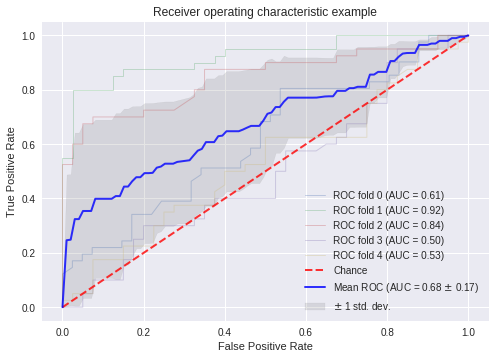

In [102]:
cv = StratifiedKFold(n_splits = 5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X = X_complet
y = y_complet

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()